Strategy description:
1.General description
2.Download Data
4.Factor construction
5.Linear Model Combine Factors

Factor1: Long_Short Ratio

                    Strategy
------------------  ----------
Start Period        2022-02-10
End Period          2023-09-01
Risk-Free Rate      0.0%
Time in Market      48.0%

Cumulative Return   109.1%
CAGR﹪              38.72%

Sharpe              0.98
Prob. Sharpe Ratio  93.42%
Sortino             1.58
Sortino/√2          1.12
Omega               1.3

Max Drawdown        -26.14%
Longest DD Days     242

Gain/Pain Ratio     0.3
Gain/Pain (1M)      1.98

Payoff Ratio        1.24
Profit Factor       1.3
Common Sense Ratio  1.5
CPC Index           0.83
Tail Ratio          1.15
Outlier Win Ratio   10.62
Outlier Loss Ratio  3.29

MTD                 0.0%
3M                  -8.02%
6M                  23.51%
YTD                 19.33%
1Y                  47.17%
3Y (ann.)           38.72%
5Y (ann.)           38.72%
10Y (ann.)          38.72%
All-time (ann.)     38.72%

Avg. Drawdown       -7.19%
Avg. Drawdown Days  33
Recovery Factor     3.58
Ulcer Index         0.12
Serenity Index      0.98


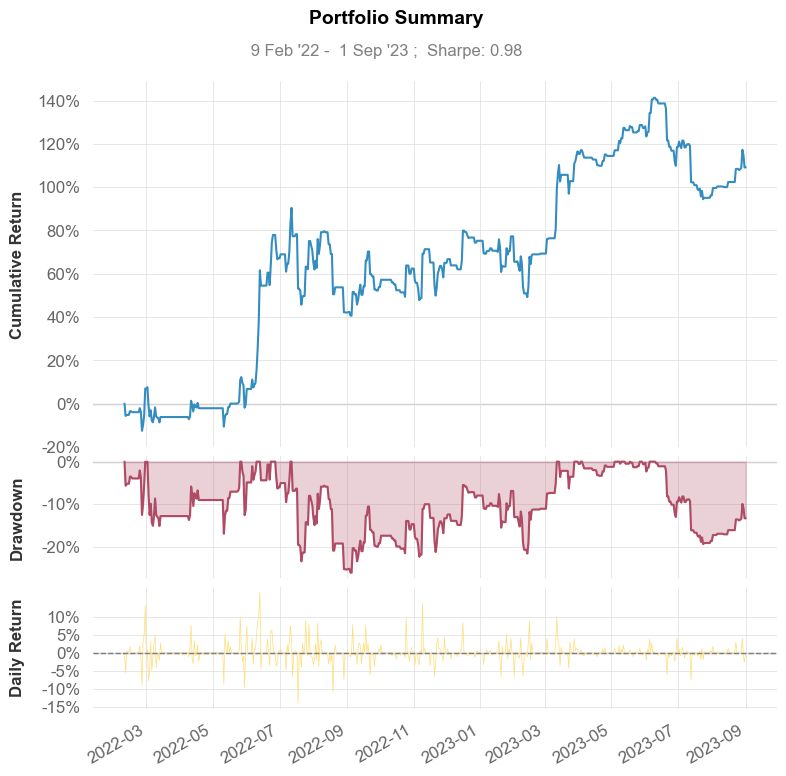

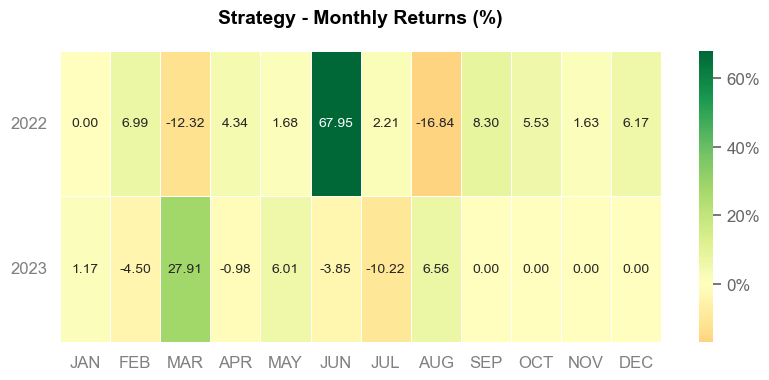

In [29]:
import numpy as np

import quantstats as qs
import pandas as pd


file = "Long_Short_Ratio_daily.parquet"
df = pd.read_parquet(f".\\Pnl\\{file}")
df = df[101:]
df.set_index("Date",inplace = True)
df.index = pd.to_datetime(df.index)
qs.reports.basic(df["Pnl_defee"])

Factor2: BIAS

                    Strategy
------------------  ----------
Start Period        2022-02-10
End Period          2023-09-01
Risk-Free Rate      0.0%
Time in Market      53.0%

Cumulative Return   97.18%
CAGR﹪              35.15%

Sharpe              0.94
Prob. Sharpe Ratio  92.46%
Sortino             1.49
Sortino/√2          1.05
Omega               1.27

Max Drawdown        -36.8%
Longest DD Days     136

Gain/Pain Ratio     0.27
Gain/Pain (1M)      1.73

Payoff Ratio        1.2
Profit Factor       1.27
Common Sense Ratio  1.59
CPC Index           0.79
Tail Ratio          1.25
Outlier Win Ratio   8.64
Outlier Loss Ratio  3.4

MTD                 0.0%
3M                  9.55%
6M                  30.12%
YTD                 18.26%
1Y                  70.82%
3Y (ann.)           35.15%
5Y (ann.)           35.15%
10Y (ann.)          35.15%
All-time (ann.)     35.15%

Avg. Drawdown       -8.46%
Avg. Drawdown Days  33
Recovery Factor     2.35
Ulcer Index         0.14
Serenity Index      0.61


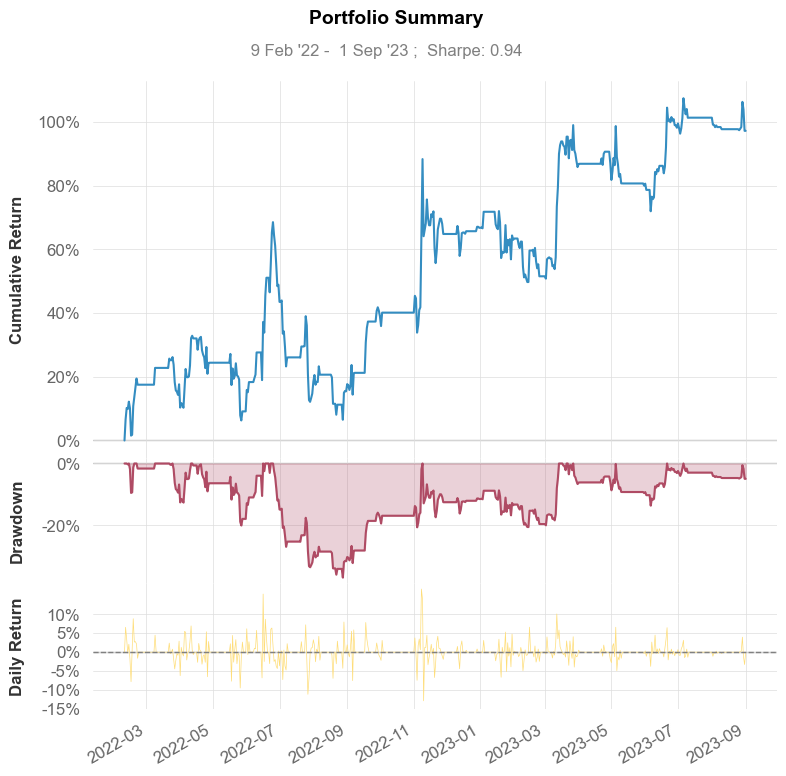

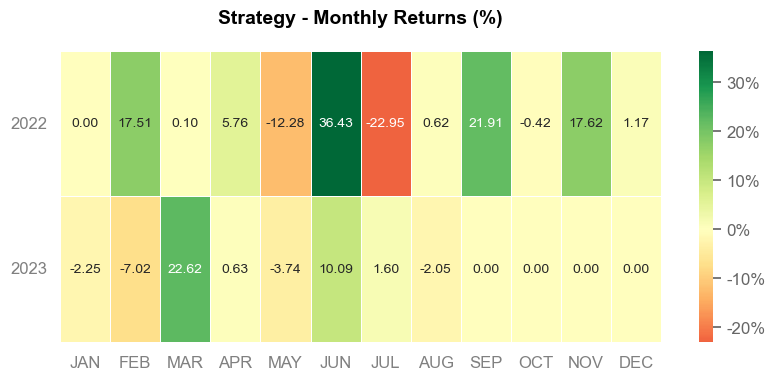

In [30]:
file = "BIAS_daily.parquet"
df = pd.read_parquet(f".\\Pnl\\{file}")
df = df[101:]
df.set_index("Date",inplace = True)
df.index = pd.to_datetime(df.index)
qs.reports.basic(df["Pnl_defee"])

Factor3: Price-Volume Correlation

                    Strategy
------------------  ----------
Start Period        2022-02-10
End Period          2023-09-01
Risk-Free Rate      0.0%
Time in Market      56.0%

Cumulative Return   293.4%
CAGR﹪              83.61%

Sharpe              1.67
Prob. Sharpe Ratio  99.6%
Sortino             2.93
Sortino/√2          2.07
Omega               1.58

Max Drawdown        -31.56%
Longest DD Days     116

Gain/Pain Ratio     0.58
Gain/Pain (1M)      3.14

Payoff Ratio        1.44
Profit Factor       1.58
Common Sense Ratio  2.44
CPC Index           1.19
Tail Ratio          1.54
Outlier Win Ratio   9.66
Outlier Loss Ratio  4.3

MTD                 0.0%
3M                  13.52%
6M                  15.49%
YTD                 43.85%
1Y                  100.3%
3Y (ann.)           83.61%
5Y (ann.)           83.61%
10Y (ann.)          83.61%
All-time (ann.)     83.61%

Avg. Drawdown       -6.72%
Avg. Drawdown Days  21
Recovery Factor     4.94
Ulcer Index         0.1
Serenity Index      2.1


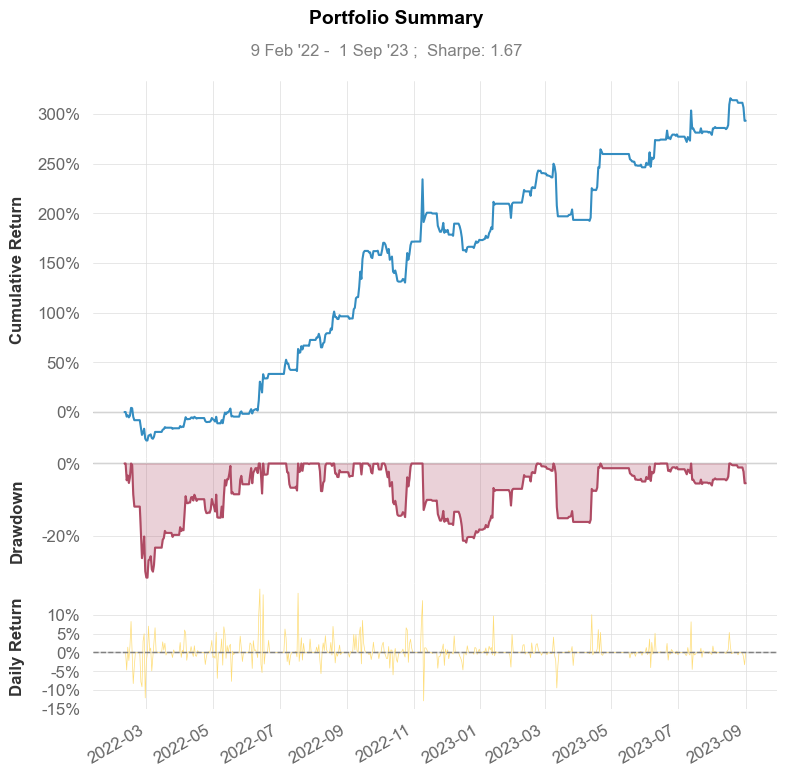

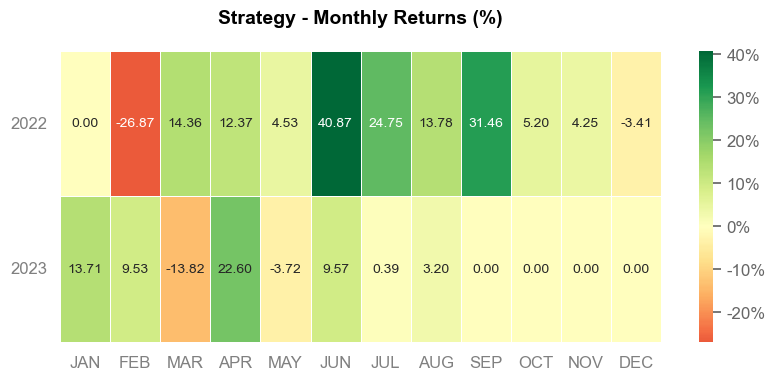

In [31]:
file = "PV_Corr_daily.parquet"
df = pd.read_parquet(f".\\Pnl\\{file}")
df = df[101:]
df.set_index("Date",inplace = True)
df.index = pd.to_datetime(df.index)
qs.reports.basic(df["Pnl_defee"])